
# Objetivo do Código

Aplicação de modelo Machine learning na manutenção preditiva previne falhas em equipamentos industriais ao analisar dados, evitando paradas não planejadas. Foram disponibilizados dados de 5 sensores presentes em uma máquina industrial. Devido a esses dados virem de sistemas reais podem ruídos e falhas dos sensores/equipamentos, para isso é necessário realizar as etapas de análise exploratória e processamento dos dados.

- Treinamento do Modelo

- Avaliação do Modelo

In [257]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

%reload_ext watermark
%watermark -a "Eric Mochiutti" --iversions

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.8
Author: Eric Mochiutti

joblib    : 1.2.0
tensorflow: 2.10.0
numpy     : 1.23.5
matplotlib: 3.6.2
keras     : 2.10.0
pandas    : 1.5.2



Carregando dados normalizados dos sensores e etiquetas

In [119]:
label_defeito = np.load('data/Classes.npy', allow_pickle=True)
dados_s1_N = np.load('data/Dados_1_normalizados.npy', allow_pickle=True)
dados_s2_N = np.load('data/Dados_2_normalizados.npy', allow_pickle=True)
dados_s3_N = np.load('data/Dados_3_normalizados.npy', allow_pickle=True)
dados_s4_N = np.load('data/Dados_4_normalizados.npy', allow_pickle=True)
dados_s5_N = np.load('data/Dados_5_normalizados.npy', allow_pickle=True)


Modificando o formato dos dados para serem inseridos empilhados e inseridos na rede neural 

- Os arquivos normalizados estão no formato numpy array 50000 x 200 e para o treinamento é necessário que sejam numpy array 50000 X 200 X 5

In [120]:
dados_s1_N_reshaped = dados_s1_N.reshape((50000, 200, 1))
dados_s2_N_reshaped = dados_s2_N.reshape((50000, 200, 1))
dados_s3_N_reshaped = dados_s3_N.reshape((50000, 200, 1))
dados_s4_N_reshaped = dados_s4_N.reshape((50000, 200, 1))
dados_s5_N_reshaped = dados_s5_N.reshape((50000, 200, 1))

stacked_data = np.concatenate([dados_s1_N_reshaped, dados_s2_N_reshaped, dados_s3_N_reshaped, dados_s4_N_reshaped, dados_s5_N_reshaped], axis=-1)

print(np.shape(stacked_data))


- Criando rótulos para a classificação (encoding para classificação)



    [1, 0, 0, 0, 0] ---> Classe A
    [0, 1, 0, 0, 0] ---> Classe B
    [0, 0, 1, 0, 0] ---> Classe C
    [0, 0, 0, 1, 0] ---> Classe D
    [0, 0, 0, 0, 1] ---> Classe E


In [258]:
encoder = OneHotEncoder(sparse_output=False)

label_one_hot = encoder.fit_transform(label_defeito)

#print(label_one_hot.shape)

#print(label_one_hot)

- Dividindo os dados em dados de teste e de treino em uma proporção 70-30

In [259]:
# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(stacked_data, label_one_hot, test_size=0.3, random_state=42)

num_classes = len(np.unique(y_train))

# Verificar os shapes
print("Shape de x_train:", x_train.shape)
print("Shape de x_test:", x_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de x_train: (35000, 200, 5)
Shape de x_test: (15000, 200, 5)
Shape de y_train: (35000, 5)
Shape de y_test: (15000, 5)


### Construindo o Modelo

- O modelo escolhido foi baseado em um trabalho que classifica séries temporais

- Rede Neural Convolucional 

In [127]:
def make_model(input_shape):
    
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(5, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape = x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Treinamento do modelo

In [128]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/500
875/875 [==============================] - 14s 15ms/step - loss: 1.0575 - accuracy: 0.5960 - val_loss: 11.4380 - val_accuracy: 0.1956 - lr: 0.0010
Epoch 2/500
875/875 [==============================] - 14s 16ms/step - loss: 0.4079 - accuracy: 0.8710 - val_loss: 3.8983 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 3/500
875/875 [==============================] - 13s 15ms/step - loss: 0.2768 - accuracy: 0.9099 - val_loss: 11.9761 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 4/500
875/875 [==============================] - 13s 15ms/step - loss: 0.2243 - accuracy: 0.9223 - val_loss: 5.1333 - val_accuracy: 0.3710 - lr: 0.0010
Epoch 5/500
875/875 [==============================] - 14s 15ms/step - loss: 0.1963 - accuracy: 0.9317 - val_loss: 11.1495 - val_accuracy: 0.2057 - lr: 0.0010
Epoch 6/500
875/875 [==============================] - 13s 15ms/step - loss: 0.1704 - accuracy: 0.9401 - val_loss: 11.1874 - val_accuracy: 0.2026 - lr: 0.0010
Epoch 7/500
875/875 [===========================

- Previsões do modelo treinado (dados de teste)

In [ ]:

previsoes = model.predict(x_test)


# Avaliação do Modelo Treinado

- R2 score (avaliar os resultados reais com as previsões do modelo)
- Funções de Custo (avaliar se o treino estava sendo efetivo)
- Matriz de Confusão (Avaliar Falsos-negativos e Falsos-Positivos)
- Class Report (Verifica a precisão, F1-score e recall para cada classe)
- ROC e UAC

R2 score

In [132]:
print("O R2 Score do Modelo é:", r2_score(y_test, previsoes) * 100)


O R2 Score do Modelo é: 94.27176449991755


Gráfico função de custo

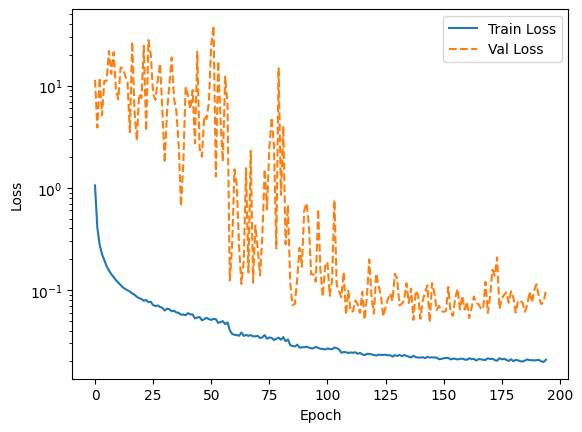

In [177]:
def plot_loss(history, label):
  
  plt.semilogy(history.epoch, history.history['loss'],
               label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

plot_loss(history, "Loss")
plt.legend()

Fazendo o deconding de [1, 0, 0, 0, 0] para valores de 0 a 4 para analise da matriz de confusão

In [167]:
y_test_decode = tf.argmax(y_test, axis = 1)
previsoes_decode = tf.argmax(previsoes, axis = 1)



Matriz de Confusão

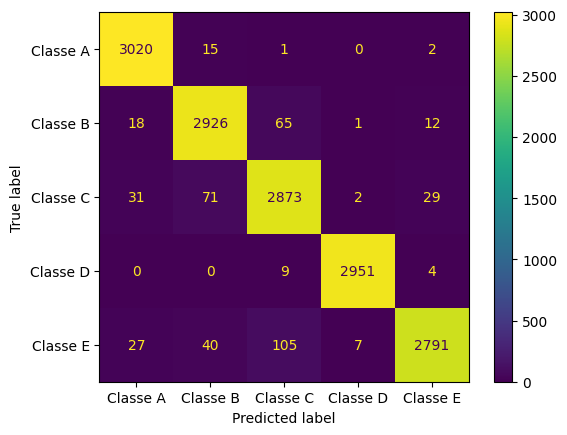

In [169]:
cm = confusion_matrix(y_test_decode, previsoes_decode)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Classe A', 'Classe B', 'Classe C', 'Classe D', 'Classe E'])

disp.plot()

A análise da matriz de confusão mostra que os acertos (amarelos) são a maioria para cada classe, entretanto é importante notar que existem regiões que apresentam alguns erros como a previsão de Classe C sendo o resultado real Classe E em 105 casos.

É necessário então mais informações do problema físico relacionado a esses exemplos, vamos supor que seja um falha catastrófica que possa ocorrer com essa previsão incorreta, esse valor então não seria aceitável. Para decisão seria necessário mais informações do processo como um todo. Entretanto iremos trabalhar com a hipótese de que não é relevante esse erro (erro baixo) para dar continuidade ao estudo de caso.

Relatório de cada Classe

In [185]:
class_report = classification_report(list(y_test_decode), previsoes_decode)


| Classe | Precisão | Revocação | Pontuação F1 | Suporte |
|--------|----------|-----------|--------------|---------|
| Classe A | 0.98 | 0.99 | 0.98 | 3038 |
| Classe B | 0.96 | 0.97 | 0.96 | 3022 |
| Classe C | 0.94 | 0.96 | 0.95 | 3006 |
| Classe D | 1.00 | 1.00 | 1.00 | 2964 |
| Classe E | 0.98 | 0.94 | 0.96 | 2970 |

<br>

- Acurácia: 0.97
- Média ponderada de precisão: 0.97
- Média ponderada de revocação: 0.97
- Média ponderada da pontuação F1: 0.97
- Total de amostras: 15000

# Calcular a curva ROC


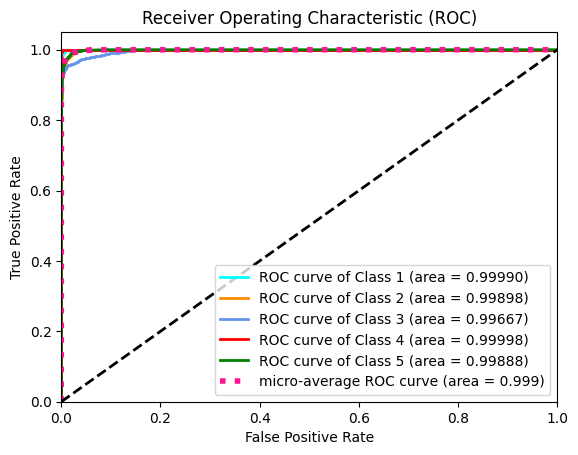

In [232]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 5

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], previsoes[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular a média das curvas ROC para micro/macro-averaging
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), previsoes.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotar a curva ROC
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green']) # Adicione mais cores conforme o número de classes
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of Class {0} (area = {1:0.5f})'
             ''.format(i+1, roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


    Análise da curva ROC
    
    - Alta Capacidade de Discriminação: Os valores AUC de 0.99 indicam que o modelo pode distinguir efetivamente entre as cinco classes.

    - Confiabilidade do Modelo: A alta AUC sugere que o modelo gera probabilidades precisas para cada classe.

    - Potencial para Aplicações Diversas: O modelo pode ser aplicado em várias áreas (do gráfico) devido à sua capacidade de classificar com precisão diferentes categorias.

    OBS: Importância da Validação Adicional: Apesar da alta AUC, é crucial validar o modelo para garantir seu desempenho confiável em situações reais.

# Análise final:

- O modelo da rede neural treinado com base nos dados apresentados mostrou-se um bom candidato a aplicação e deploy na appweb desenvolvida na etapa a seguir.